# 📊 Proyecto: Análisis de ventas de videojuegos y planificación de campaña 2017

Trabajé con datos abiertos de reseñas (usuarios y críticos), géneros, plataformas y ventas históricas para identificar patrones que determinan el éxito comercial de los videojuegos. El objetivo fue detectar títulos y plataformas prometedoras, así como planificar campañas publicitarias para 2017, utilizando información disponible hasta 2016 y aplicando buenas prácticas de análisis reproducible.

---

## 🎯 Objetivo
Identificar patrones de éxito en ventas de videojuegos usando datos hasta 2016 y planificar campañas 2017.

---
## 📂 Descripción de los datos
- Fuente principal: games.csv.
- Variables clave: Name, Platform, Year_of_Release, Genre, NA_sales, EU_sales, JP_sales, Other_sales, Critic_Score, User_Score, Rating (ESRB).
- Notas: Posibles datos incompletos en 2016; se creó Total_sales sumando NA, EU, JP y Other.
- Periodo de interés: Se seleccionó según estabilidad y relevancia de plataformas (aparecen/desaparecen), distribución anual de lanzamientos y consistencia de ventas.



### Importación de librerías

In [2]:
# Cargar todas las librerías
from matplotlib import pyplot as plt
from functools import reduce
from scipy import stats as st
import pandas as pd
import numpy as np
import seaborn as sns

### Carga de datos

In [3]:
# Importar Dataframe 
games = pd.read_csv('games.csv')
# Información del data frame 
games.info()
# Impresión de las primeras 5 líneas iniciales del data frame
print(games.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
                       Name Platform  Year_of_Release         Genre  NA_sales  \
0                Wii Sports      Wii           2006.0        Sports     41.36   
1         Super Mario Bros.      NES           1985.0      Platform     29.08  

De acuerdo con los datos obtenidos de la información de la tabla de videojuegos, se pueden hacer las siguientes observaciones:
- **Renombramiento de columnas:** Los nombres de las columnas deben convertirse en minúsculas para facilitar el manejo de los comandos de Pandas en posteriores operaciones y análisis de los datos.
- **Tratamiento de valores ausentes:** Aunque los valores ausentes en algunas columnas podrían considerarse insignificantes, en otras representan una cantidad mucho mayor. Por ello, es necesario verificar si existe la posibilidad de reemplazarlos o prescindir de ellos sin que se altere el análisis general de los datos.
- **Cambio de tipos de datos:** Una vez resuelto el tema de los valores ausentes, es importante ajustar los tipos de datos de las columnas a los que correspondan. Esto hará más sencillo el análisis y permitirá utilizar los métodos adecuados, siempre que las columnas tengan el tipo correcto.

## 📄 Preparación de los datos

### Renombramiento de columnas

In [4]:
# Cambio de nombres de las columnas a minúsculas
new_name = []
for ref_column in games.columns:
    new_name.append(ref_column.lower())
games.columns = new_name
print(games.columns)

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')


### Tratamiento de valores ausentes

In [5]:
# Verificación de valores ausentes
nan_values = games.isna().sum()
print('Cantidad de valores ausentes por columna: \n',nan_values,'\n')
# Calculo del porcentaje de representación de lo valores ausentes en las columnas
print('Porcentaje de valores ausentes por columna: \n',(nan_values/(len(games)))*100)

Cantidad de valores ausentes por columna: 
 name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64 

Porcentaje de valores ausentes por columna: 
 name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         40.089740
rating             40.478612
dtype: float64


Para poder modificar los valores ausentes, ya sea reemplazándolos o eliminándolos, es necesario considerar el porcentaje que representan dentro de nuestro conjunto de datos. Como se observa en el cálculo anterior, solo las columnas name, `year_of_release` y `genre` pueden ser eliminadas o modificadas, ya que representan un porcentaje muy bajo dentro del total de datos del data frame. Sin embargo, no sucede lo mismo con `critic_score`, `user_score` y `rating`, los cuales concentran entre el 40% y el 50% de los registros. Eliminar dichos datos implicaría que el conjunto dejara de ser representativo; por otro lado, aplicar métodos de reemplazo con la media o la mediana introduciría un sesgo demasiado grande, lo que haría que cualquier análisis resultara poco fiable.
A pesar de lo concluido anteriormente, es necesario verificar más características de los datos para poder tomar una decisión. Conforme se avance en esta sección, se adoptarán las decisiones pertinentes de acuerdo con lo más conveniente.


#### Columna genre

In [6]:
# Impresión de valores ausentes en la fila de género
print(games[games['genre'].isna()])
# Eliminación de las filas con valores ausentes
games = games.drop([659,14244])

      name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN           1993.0   NaN      1.78      0.53      0.00   
14244  NaN      GEN           1993.0   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN  


Como se puede observar en la sección anterior, las filas que presentan valores ausentes tanto en la columna `name` como en la columna genre son las mismas; por ende, resulta más sencillo eliminarlas. Para estos datos en particular, es preferible eliminarlos en lugar de rellenarlos, ya que no existe suficiente información que permita recuperar los campos faltantes de `name` y `genre`. Además, tampoco se dispone de datos en `critic_score`, `user_score` y `rating`. La información restante podría coincidir con cualquier juego, por lo que no resulta útil para futuros análisis.


#### Columna year_of_release

In [7]:
# Obtención de los valores únicos de los años de lanzamiento
years = pd.unique((games['year_of_release']))
print('Años de lanzamiento: \n',np.sort(years))

Años de lanzamiento: 
 [1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987. 1988. 1989. 1990. 1991.
 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999. 2000. 2001. 2002. 2003.
 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015.
 2016.   nan]


In [8]:
old_games = games[games['year_of_release'] < 2000]
print('Porcentaje de valores ausentes en los datos de antes del 2000: \n', (old_games[['critic_score','user_score']].isna().sum()/games[['critic_score','user_score']].isna().sum())*100)

Porcentaje de valores ausentes en los datos de antes del 2000: 
 critic_score    21.898321
user_score      27.959397
dtype: float64


De acuerdo con lo calculado, es evidente que la cantidad de valores ausentes correspondientes a los años anteriores al 2000 oscila entre el 21% y el 27% del total de los datos. En un primer análisis se pensó que los datos representarían una proporción mucho mayor, pues inicialmente se creía que la práctica de asignar puntuaciones a los videojuegos se popularizó en años próximos al 2000. Sin embargo, esto no es cierto, ya que dicha práctica comenzó desde la década de los 80.

A pesar de ello, no todos los juegos cuentan con una reseña, lo cual puede deberse a diversos factores, como la falta de promoción o distribución, el carácter experimental o reducido de algunos títulos, entre otros aspectos.

#### Columna critic_score

In [9]:
# Filtrado por valores ausentes de la columna critic_score
critic_games = games[games['critic_score'].isna()]
print('Porcentaje de representación de los valores ausentes por cada año: \n',(critic_games.groupby('year_of_release')['name'].count()/games.groupby('year_of_release')['name'].count())*100)

Porcentaje de representación de los valores ausentes por cada año: 
 year_of_release
1980.0    100.000000
1981.0    100.000000
1982.0    100.000000
1983.0    100.000000
1984.0    100.000000
1985.0     92.857143
1986.0    100.000000
1987.0    100.000000
1988.0     93.333333
1989.0    100.000000
1990.0    100.000000
1991.0    100.000000
1992.0     97.674419
1993.0    100.000000
1994.0     99.173554
1995.0    100.000000
1996.0     96.958175
1997.0     94.117647
1998.0     92.612137
1999.0     88.461538
2000.0     59.142857
2001.0     32.365145
2002.0     24.366707
2003.0     24.516129
2004.0     26.377953
2005.0     30.244941
2006.0     38.369781
2007.0     42.188805
2008.0     49.894884
2009.0     54.347826
2010.0     60.159363
2011.0     55.985915
2012.0     50.842266
2013.0     49.816176
2014.0     55.077453
2015.0     62.871287
2016.0     53.784861
Name: name, dtype: float64


De acuerdo con la agrupación de datos mostrada anteriormente, se observa que desde 1980 hasta 1999 los valores ausentes representan la mayoría, o incluso la totalidad, de los datos correspondientes a esos años. Por ello, la mejor opción podría ser conservar únicamente los datos del año 2000 en adelante.

Aunque lo anterior puede parecer razonable, el análisis realizado en la sección previa arrojó que dichos años solo representan el 21% de los valores ausentes totales; el resto se encuentra distribuido entre los años posteriores al 2000. Eliminar o reemplazar estos datos no mejoraría de manera significativa el estudio posterior y, además, implicaría descartar información que sí aporta valor. Por lo tanto, lo más adecuado sería mantenerlos sin modificación

#### Columna user_score

In [10]:
# Obtención de valores únicos de user_score
print(pd.unique(games['user_score']))

['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']


In [11]:
# Reemplazo de los valores tbd
games['user_score'] = games['user_score'].replace('tbd',-1)

De todo el conjunto de valores únicos, el que destaca es el definido como **tbd**. De acuerdo con la información obtenida, las puntuaciones **tbd** se asignan cuando el juego aún no tiene una calificación. Para fines prácticos, se podrían reemplazar por un valor numérico negativo, lo que permitiría convertirlos al tipo de dato correspondiente y manipularlos sin problema.


#### Columna rating

In [12]:
# Obtención de los valores únicos del rating
print(pd.unique(games['rating']))

['E' nan 'M' 'T' 'E10+' 'K-A' 'AO' 'EC' 'RP']


Dentro de los datos, la calificación **K-A** llama la atención entre las demás. Tras una investigación adicional, se encontró que dicha calificación fue renombrada como E después de 1998. Por lo tanto, esos datos pueden reemplazarse para su análisis posterior.

In [13]:
# Reemplazo de los valores del rating
games['rating'] = games['rating'].replace('K-A','E')
print(pd.unique(games['rating']))

['E' nan 'M' 'T' 'E10+' 'AO' 'EC' 'RP']


In [14]:
# Reemplazo de los valores ausentes para el rating
games['rating'] = games['rating'].fillna('Unknown')
rating = games.groupby('rating')['name'].count()
print('Número de juegos por rating: \n',rating)
print('Porcentaje de juegos conrating desconocido \n',(rating/len(games['rating']))*100)

Número de juegos por rating: 
 rating
AO            1
E          3993
E10+       1420
EC            8
M          1563
RP            3
T          2961
Unknown    6764
Name: name, dtype: int64
Porcentaje de juegos conrating desconocido 
 rating
AO          0.005983
E          23.891581
E10+        8.496380
EC          0.047867
M           9.352001
RP          0.017950
T          17.716747
Unknown    40.471489
Name: name, dtype: float64


Para los valores ausentes se decidió conservarlos en lugar de eliminarlos, incluso antes que rellenarlos, con el fin de mantenerlos visibles. Aunque pudiera parecer que no son importantes, al comparar con los demás valores se observa que representan casi el 41% del total de los datos, lo cual no puede considerarse prescindible para un buen análisis.

### Conversión de datos


In [15]:
# Cambiar los tipos de datos a los correspondientes
games['year_of_release'] = games['year_of_release'].astype('Int64')
# Cambiar los tipos de datos a los correspondientes
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')
games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  float64
 10  rating           16713 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


Las columnas `year_of_release` y `user_score` tuvieron que cambiarse de tipo de dato. En el primer caso, los años estaban en formato flotante, lo cual no es conveniente, ya que ocupa más memoria y, además, no se realizan operaciones que requieran ese tipo de dato. Por otro lado, las puntuaciones de los usuarios fueron convertidas a flotantes, pues por su naturaleza este es el tipo de dato que corresponde. En este caso, es más probable que se necesiten operaciones aritméticas, por lo que resulta necesario utilizar un formato numérico.


### Cálculo de ventas totales

In [16]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
print(games.head())

                       name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Mario Bros.      NES             1985      Platform     29.08   
2            Mario Kart Wii      Wii             2008        Racing     15.68   
3         Wii Sports Resort      Wii             2009        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score  user_score   rating  \
0     28.96      3.77         8.45          76.0         8.0        E   
1      3.58      6.81         0.77           NaN         NaN  Unknown   
2     12.76      3.79         3.29          82.0         8.3        E   
3     10.93      3.28         2.95          80.0         8.0        E   
4      8.89     10.22         1.00           NaN         NaN  Unknown   

   total_sales  
0        82.54  
1        40.24  
2        35.52  
3     

## 📈 Análisis de los datos

### Juégos lanzados anualmente

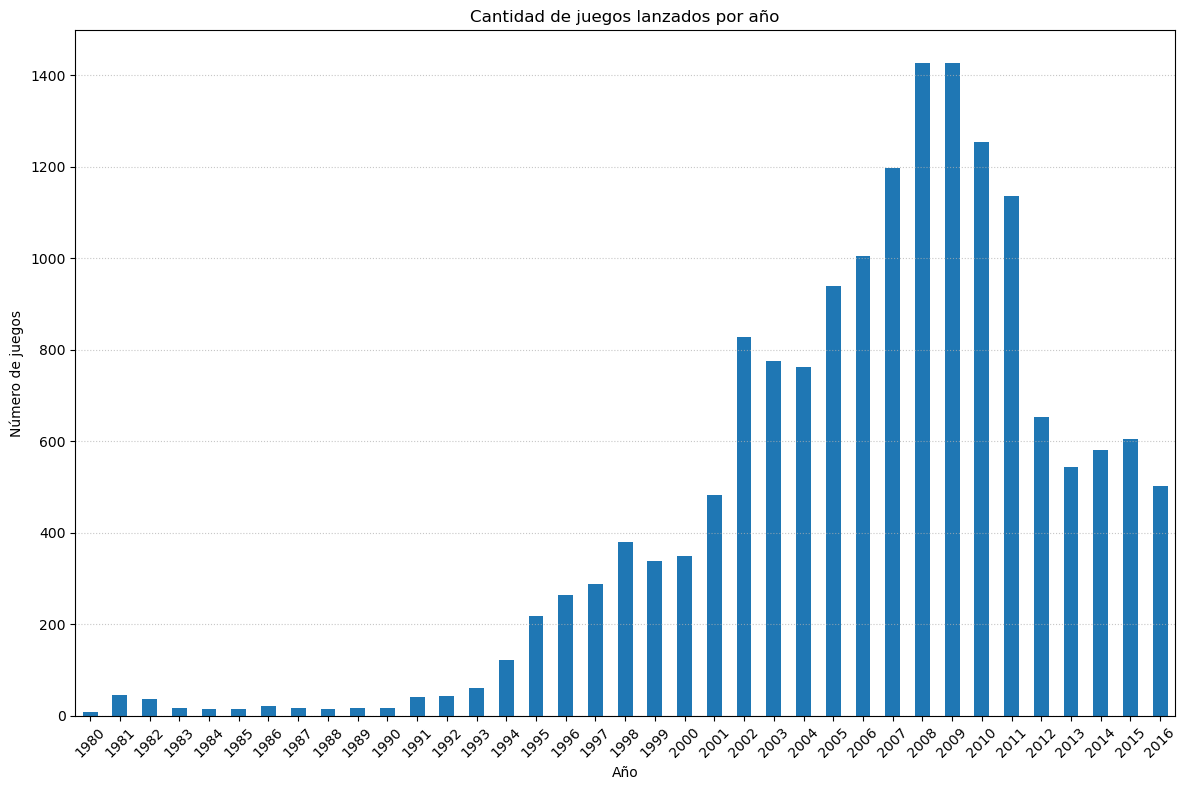

In [17]:
# Graficación de los juegos lanzados por año
games_released = games.groupby('year_of_release')['name'].count()
games_released.plot(kind='bar',
                    title='Cantidad de juegos lanzados por año',
                    xlabel='Año',
                    ylabel='Número de juegos',
                    rot=45,
                    figsize=[12,8]
                   )
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

Con respecto a la gráfica anterior, se podría considerar que los datos comienzan a ser significativos a partir del año 1995, cuando se empieza a observar una tendencia en aumento. Aunque los datos previos a esa fecha son escasos, esto no significa que no existan más registros, ya que conforme avanzaron los años se fue estableciendo un estándar en la industria de los videojuegos hasta convertirse en lo que conocemos hoy.

### Variaciones de ventas entre plataformas

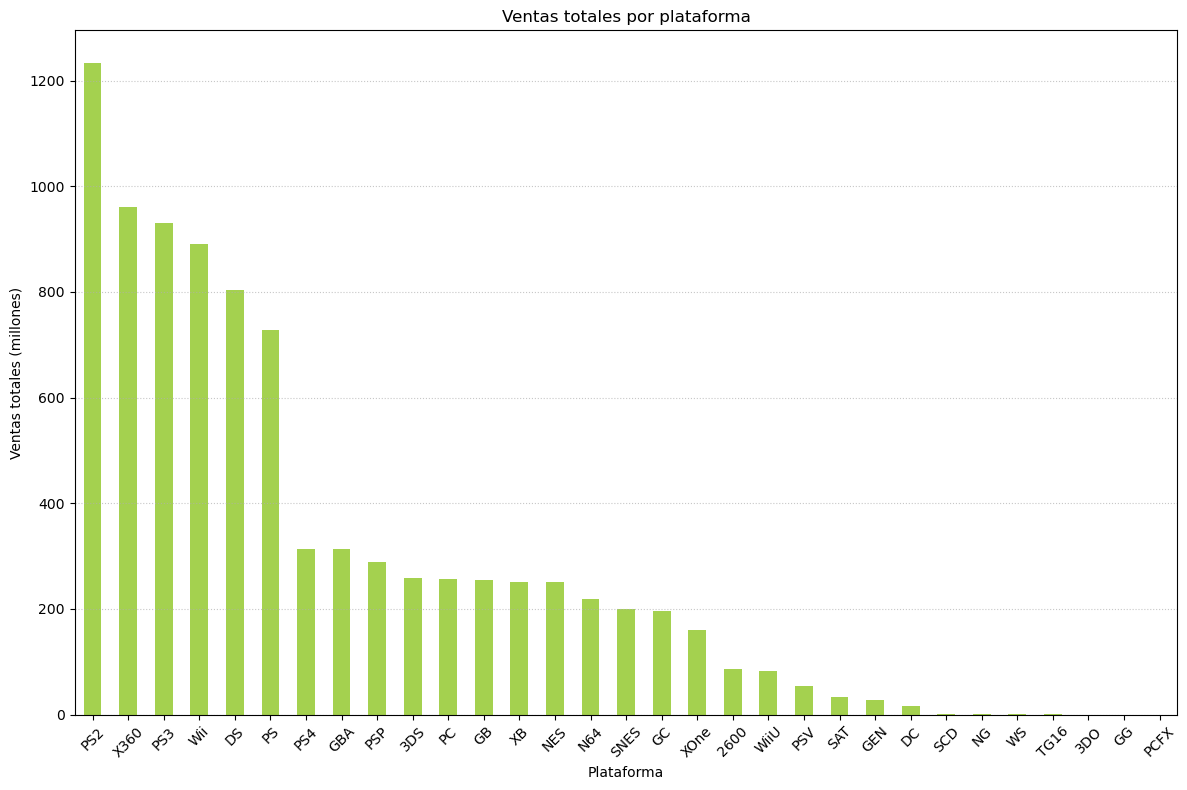

In [46]:
platforms_sales = games.pivot_table(index=['platform','year_of_release'],values='total_sales',aggfunc='sum').reset_index().sort_values(by=['platform','year_of_release','total_sales'],ascending=False)
platform_total = platforms_sales.groupby('platform')['total_sales'].sum().sort_values(ascending=False)
#print('Ventas totales por plataforma: \n',platform_total)
platform_total.plot(kind='bar',
                    title='Ventas totales por plataforma',
                    xlabel='Plataforma',
                    ylabel='Ventas totales (millones)',
                    color="#A4D14F",
                    rot=45,
                    figsize=[12,8]
                   )
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

Se puede observar una gran diferencia en las ventas de títulos entre las distintas plataformas. Incluso, a simple vista, es posible identificar aquellas consolas que fueron más populares frente a las que no lograron consolidarse. Del mismo modo, se distinguen plataformas con ventas considerables y otras con un desempeño mucho más bajo.

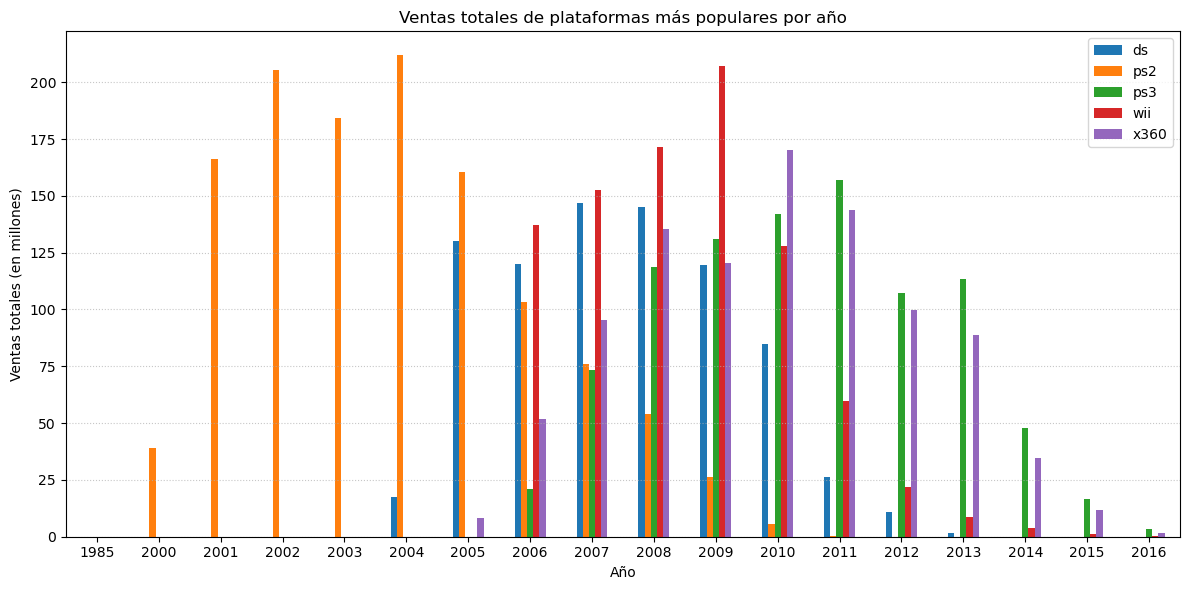

In [19]:
platforms = ['PS2', 'X360', 'Wii', 'PS3', 'DS']
most_popular = platforms_sales[platforms_sales['platform'].isin(platforms)]
pivot_popular = most_popular.pivot_table(index='year_of_release',columns='platform',values='total_sales',aggfunc='sum').fillna(0)
pivot_popular = pivot_popular.rename(columns={'PS2': 'total_sales_ps2','X360': 'total_sales_x360','Wii': 'total_sales_wii','PS3': 'total_sales_ps3','DS': 'total_sales_ds'})
pivot_popular = pivot_popular.reset_index()
popular_console_sales = pivot_popular.columns.drop('year_of_release')
pivot_popular.plot(kind='bar',
              x='year_of_release',
              y=popular_console_sales,
              title='Ventas totales de plataformas más populares por año',
              xlabel='Año',
              ylabel='Ventas totales (en millones)',
              figsize=(12,6),
              rot=0
             )
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.legend([col.split('_')[-1] for col in popular_console_sales])
plt.tight_layout()
plt.show()

En la gráfica anterior es visible el comportamiento de las ventas de videojuegos en las distintas consolas. El patrón del ciclo de vida de cada consola puede observarse desde el momento en que los juegos se lanzan hasta que dejan de registrarse compras de dichos títulos. Un aspecto curioso es que tienden a mostrar un patrón muy similar en sus ventas, variando únicamente en la duración del ciclo y en la cantidad de ventas. Por ende, es posible estimar el tiempo promedio de vida de las consolas.

In [20]:
time = []
for platform in platforms:
    years = (games[(games['platform'] == platform) & ~(games['year_of_release'].isna())]['year_of_release'].max()) - (games[(games['platform'] == platform) & ~(games['year_of_release'].isna()) & (games['year_of_release'] > 1985)]['year_of_release'].min())
    time.append(int(years))
print('Promedio de años de vida de consolas más populares:',sum(time)/len(time))

Promedio de años de vida de consolas más populares: 10.2


In [21]:
ps2_release = games[games['platform'] == 'PS2']['year_of_release'].min() - games[games['platform'] == 'PS']['year_of_release'].min()
ps3_release = games[games['platform'] == 'PS3']['year_of_release'].min() - games[games['platform'] == 'PS2']['year_of_release'].min()
ps4_release = games[games['platform'] == 'PS4']['year_of_release'].min() - games[games['platform'] == 'PS3']['year_of_release'].min()
print('Años que tardan las nuevas consolas en aparecer:\n','PS2:',ps2_release,'\n','PS3:',ps3_release,'\n','PS4:',ps4_release)

Años que tardan las nuevas consolas en aparecer:
 PS2: 6 
 PS3: 6 
 PS4: 7


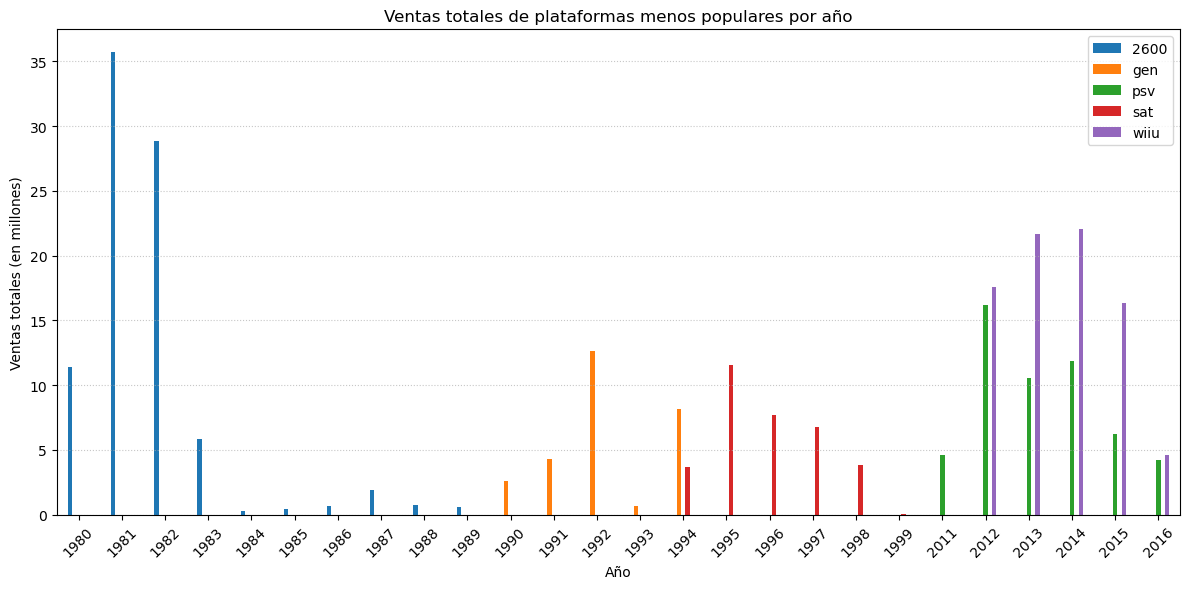

In [22]:
platforms_lp = ['2600', 'GEN', 'SAT', 'PSV', 'WiiU']
less_pupular = platforms_sales[platforms_sales['platform'].isin(platforms_lp)]
pivot_lpopular = less_pupular.pivot_table(index='year_of_release',columns='platform',values='total_sales',aggfunc='sum').fillna(0)
pivot_lpopular = pivot_lpopular.rename(columns={'2600': 'total_sales_2600','GEN': 'total_sales_gen','SAT': 'total_sales_sat','PSV': 'total_sales_psv','WiiU': 'total_sales_wiiu'})
pivot_lpopular = pivot_lpopular.reset_index()
lpopular_console_sales = pivot_lpopular.columns.drop('year_of_release')
pivot_lpopular.plot(kind='bar',
              x='year_of_release',
              y=lpopular_console_sales,
              title='Ventas totales de plataformas menos populares por año',
              xlabel='Año',
              ylabel='Ventas totales (en millones)',
              figsize=(12,6),
              rot=45
             )
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.legend([col.split('_')[-1] for col in lpopular_console_sales])
plt.tight_layout()
plt.show()

Es evidente en la gráfica que, a diferencia del comportamiento en las ventas de los juegos para las consolas más populares, aquellas que no lo son presentan una menor cantidad tanto de ventas como de tiempo de vida. Aun así, muestran un comportamiento muy similar, que se asemeja a una distribución casi simétrica en la mayoría de los casos: alcanzan su mayor volumen de ventas hacia la mitad del ciclo de vida de la consola y posteriormente descienden hasta no registrar ventas y quedar obsoletas.

In [23]:
time_lp = []
for platform in platforms_lp:
        years_lp = (games[(games['platform'] == platform) & ~(games['year_of_release'].isna())]['year_of_release'].max()) - (games[(games['platform'] == platform) & ~(games['year_of_release'].isna())]['year_of_release'].min())
        time_lp.append(int(years_lp))
print('Promedio de años de vida de consolas menos populares:',sum(time_lp)/len(time_lp))

Promedio de años de vida de consolas menos populares: 5.4


Con el análisis realizado anteriormente, se puede concluir que las consolas populares tardan aproximadamente 10 años en desaparecer, mientras que las menos populares tienen un ciclo de vida cercano a los 5 años. Por otro lado, el tiempo que transcurre entre la aparición de nuevas consolas varía considerablemente, ya que el mercado se ajusta a las tendencias marcadas por distintos juegos, empresas y tipos de consolas. Haciendo un cálculo rápido entre las apariciones de las consolas de Sony, el tiempo promedio fue de 6 años entre cada lanzamiento.

Si bien este dato puede parecer contundente, aún es necesario analizar otros factores que influyen en las ventas, como la piratería, la popularidad de los juegos de cada plataforma, el costo, entre otros aspectos relevantes.


### Filtrado de datos

In [24]:
recent_games = games[games['year_of_release'] > 1999]
print(recent_games.head())
print(pd.unique(recent_games['platform']))

                    name platform  year_of_release     genre  na_sales  \
0             Wii Sports      Wii             2006    Sports     41.36   
2         Mario Kart Wii      Wii             2008    Racing     15.68   
3      Wii Sports Resort      Wii             2009    Sports     15.61   
6  New Super Mario Bros.       DS             2006  Platform     11.28   
7               Wii Play      Wii             2006      Misc     13.96   

   eu_sales  jp_sales  other_sales  critic_score  user_score rating  \
0     28.96      3.77         8.45          76.0         8.0      E   
2     12.76      3.79         3.29          82.0         8.3      E   
3     10.93      3.28         2.95          80.0         8.0      E   
6      9.14      6.50         2.88          89.0         8.5      E   
7      9.18      2.93         2.84          58.0         6.6      E   

   total_sales  
0        82.54  
2        35.52  
3        32.77  
6        29.80  
7        28.91  
['Wii' 'DS' 'X360' 'PS3' '

### Rentabilidad de las plataformas

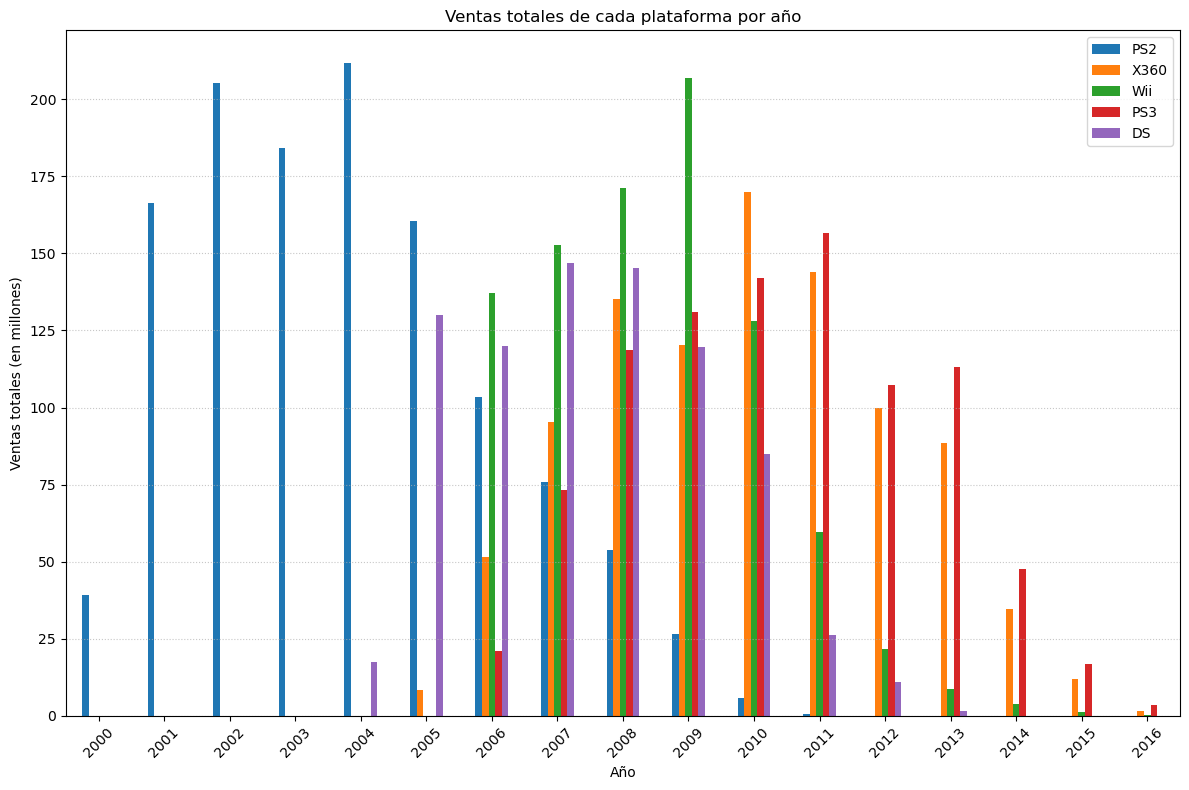

In [25]:
best_sales = recent_games.pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').fillna(0).reset_index().sort_values(by='year_of_release')
best_sales = best_sales[['year_of_release','PS2', 'X360', 'Wii', 'PS3', 'DS']]
best_sales.plot(kind='bar',
              x='year_of_release',
              y=platforms,
              title='Ventas totales de cada plataforma por año',
              xlabel='Año',
              ylabel='Ventas totales (en millones)',
              figsize=(12,8),
              rot=45
             )
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.legend([col.split('_')[-1] for col in platforms])
plt.tight_layout()
plt.show()

Para las plataformas que abarcan del año 2000 al 2016, predominan las siguientes:
- PlayStation 2
- Xbox 360
- Wii
- PlayStation 3
- Nintendo DS

Aunque estas cinco plataformas son las que registran mejores ventas, se observa que algunas disminuyen mientras otras crecen. El ejemplo más claro es la consola ***PS2***, que comienza a decrecer en ventas mientras las demás inician su crecimiento. Entre las plataformas más rentables destacan la ***PS2***, la ***Xbox 360*** y la ***Wii***, las cuales mantuvieron ventas durante poco más de 10 años.

### Ventas globales por plataforma

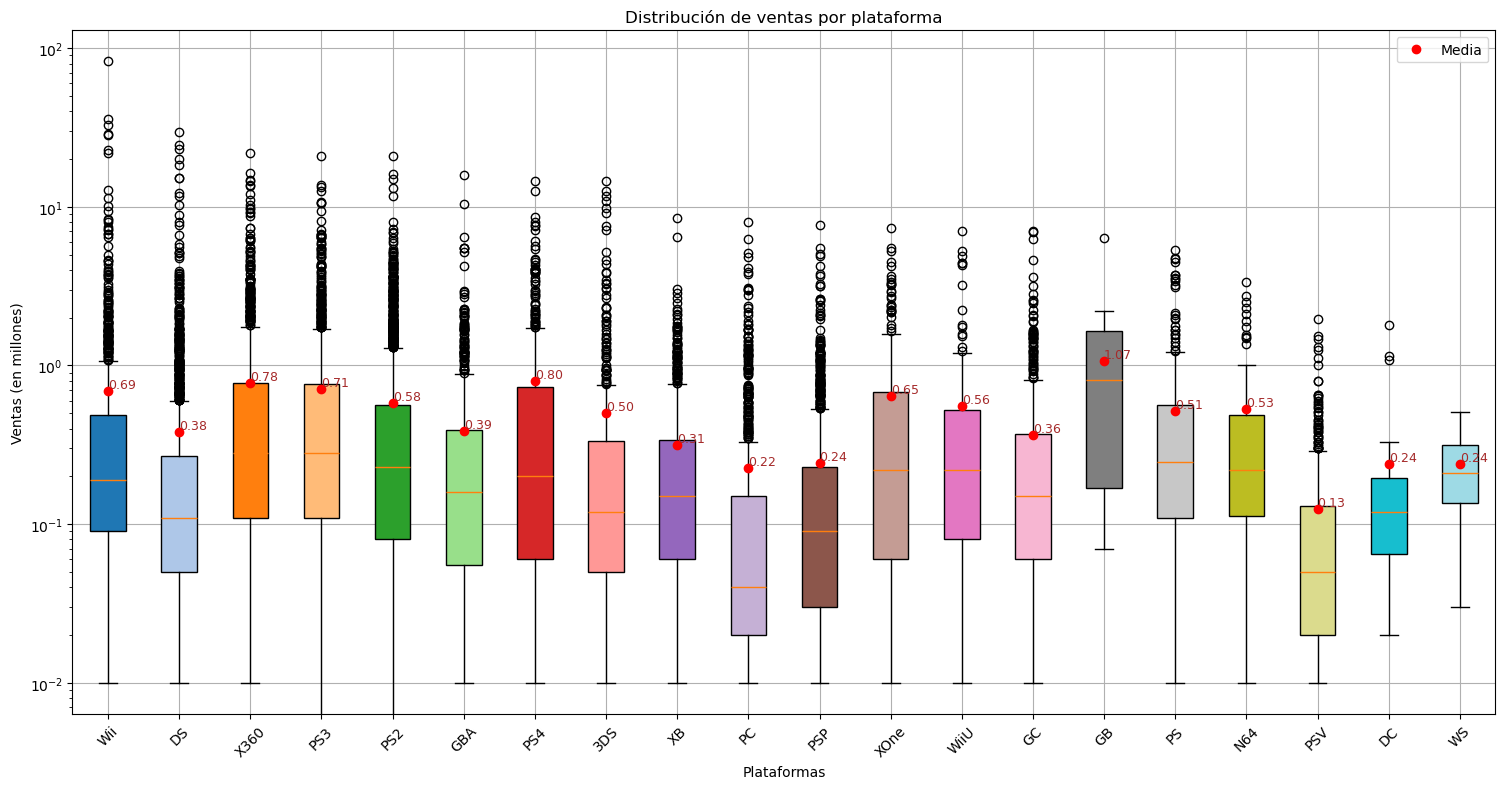

In [45]:
platforms = recent_games['platform'].unique()
sales_by_platform = []
sales_means = {}

colors = plt.cm.tab20(range(len(platforms)))

for p in platforms:
    ventas = recent_games.loc[recent_games['platform'] == p, 'total_sales']
    sales_by_platform.append(ventas)
    sales_means[p] = ventas.mean()

plt.figure(figsize=(15, 8))
box = plt.boxplot(sales_by_platform, tick_labels=platforms, patch_artist=True)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Añadir la media como punto rojo y texto
for i, p in enumerate(platforms, start=1):
    mean_val = sales_means[p]
    plt.plot(i, mean_val, 'ro', label='Media' if i == 1 else "")  # solo la primera vez
    plt.text(i, mean_val, f'{mean_val:.2f}', ha='left', va='bottom', fontsize=9, color='brown')

plt.legend()
plt.grid()
plt.title("Distribución de ventas por plataforma")
plt.xlabel("Plataformas")
plt.ylabel("Ventas (en millones)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.yscale("log")
plt.show()


Como muestra el diagrama de caja de las ventas por plataforma, se observa que, desde el **Wii** hasta la **3DS**, en algunos casos las diferencias en las ventas son significativas, mientras que en otros resultan bastante similares. Por ejemplo, plataformas como la **PS3**, la **Xbox 360** y la **Wii** presentan una media de ventas muy cercana, diferenciándose únicamente por unos cuantos millones. Sin embargo, si comparamos las ventas de la **GB** con las de la **Wii**, veremos que la primera registró muchas más ventas, lo cual significa que, en promedio, los juegos de la plataforma **GB** vendieron más unidades que los juegos de **Wii**.

Esto no implica necesariamente que el total de ventas de **GB** sea superior al de **Wii**, ni que haya tenido títulos con ventas récord como el **Wii** (que muestra un *outlier* muy alto en el gráfico). Lo que refleja es que, al calcular el promedio de ventas por juego, los títulos de **GB** tienden a tener un desempeño más consistente y elevado que los de **Wii**.

En cuanto a las medias de ciertas consolas, se puede notar que se agrupan en distintos niveles. Aunque los diagramas de caja ofrecen bastante información, debido a la naturaleza de los datos pueden resultar engañosos. Por ello, se tomó la decisión de imprimir los valores de cada media de ventas por plataforma. Allí se aprecia que algunas consolas mantienen una tendencia al alza, mientras que otras, menos populares, se posicionan junto a las más antiguas.

Si bien esta es una manera de determinar el comportamiento de las ventas dentro de cada plataforma, es importante considerar los valores atípicos, ya que pueden afectar la media. En análisis anteriores, la **PS2** aparecía como la consola con mayores ventas; sin embargo, en el presente análisis el promedio de ventas de la **GB** resulta ser el más alto. Esto no significa necesariamente que sea la consola más vendida, sino que su media se ve influenciada por la distribución de los datos.

### Correlación de ventas contra puntaciones

In [27]:
ps2_score = games[~(games['critic_score'].isna()) & ~(games['user_score'].isna()) & (games['year_of_release'] > 1999) & (games['platform'] == 'PS2')].copy()
ps2_score['user_score'] = (ps2_score['user_score'] - ps2_score['user_score'].min()) / (ps2_score['user_score'].max() - ps2_score['user_score'].min())
ps2_score['critic_score'] = (ps2_score['critic_score'] - ps2_score['critic_score'].min()) / (ps2_score['critic_score'].max() - ps2_score['critic_score'].min())
ps2_score['total_sales'] = (ps2_score['total_sales'] - ps2_score['total_sales'].min()) / (ps2_score['total_sales'].max() - ps2_score['total_sales'].min())
print(ps2_score[['critic_score', 'user_score', 'total_sales']].corr())

              critic_score  user_score  total_sales
critic_score      1.000000    0.382398     0.392536
user_score        0.382398    1.000000     0.185800
total_sales       0.392536    0.185800     1.000000


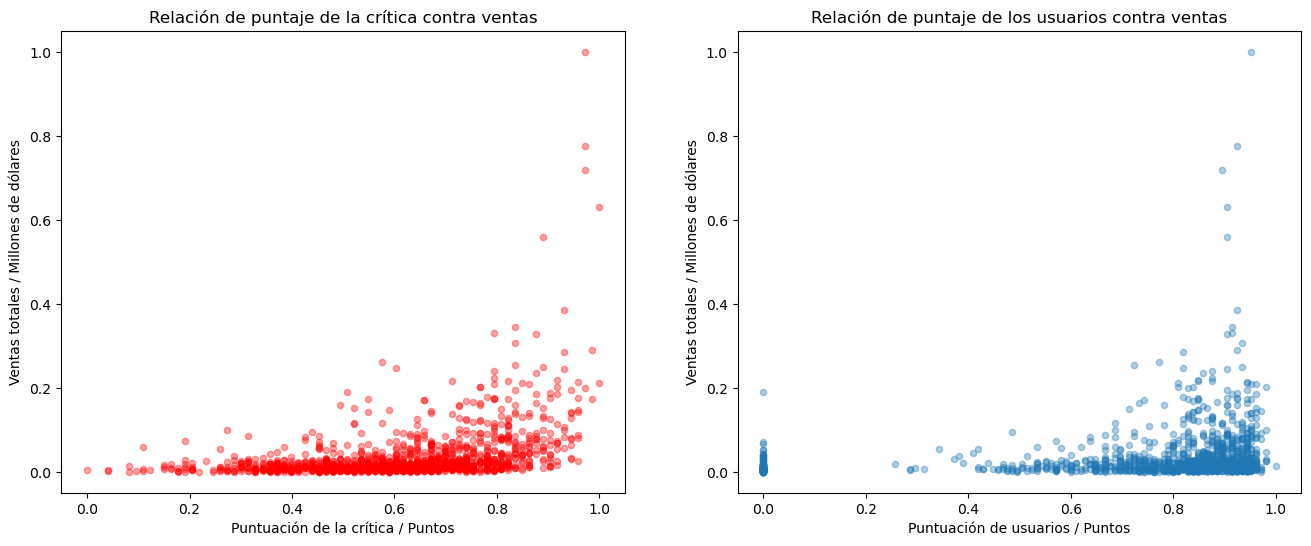

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ps2_score.plot(x='critic_score',
               y='total_sales',
               kind='scatter',
               title='Relación de puntaje de la crítica contra ventas',
               alpha=0.36,
               xlabel='Puntuación de la crítica / Puntos',
               ylabel='Ventas totales / Millones de dólares', 
               color = 'red',
               ax=ax1)

ps2_score.plot(x='user_score',
               y='total_sales',
               kind='scatter',
               title='Relación de puntaje de los usuarios contra ventas',
               alpha=0.36,
               xlabel='Puntuación de usuarios / Puntos',
               ylabel='Ventas totales / Millones de dólares', 
               ax=ax2)

plt.show()

Si bien podría parecer que las ventas de una plataforma están estrechamente relacionadas con su puntuación, el análisis visual de los diagramas de dispersión sugiere que la relación es positiva pero débil o moderada. En ambos gráficos se observa una ligera tendencia ascendente: a mayor puntuación (tanto de la crítica como de los usuarios), tienden a aumentar las ventas. Sin embargo, la dispersión de los datos es considerable.

Esto indica que la calificación influye en la percepción del producto y puede contribuir a su éxito comercial, pero no garantiza altas ventas. Existen numerosos casos de juegos con puntuaciones elevadas y ventas moderadas, así como algunos títulos con puntuaciones medias que alcanzan ventas significativas.

Además, la concentración de puntos en rangos altos de calificación con ventas relativamente bajas sugiere que otros factores desempeñan un papel determinante, tales como:

- Estrategias de marketing y distribución

- Presupuesto de desarrollo

- Popularidad de la franquicia

- Momento de lanzamiento

- Competencia en el mercado

- Tamaño de la base instalada de la plataforma

- Factores externos como piratería o reputación empresarial

Otro aspecto relevante es que la variabilidad en ventas aumenta conforme crece la puntuación, lo que sugiere que, aunque una buena calificación puede abrir la posibilidad de mayores ventas, el desempeño final depende de múltiples variables adicionales.

En conclusión, no se observa una correlación fuerte entre puntuación y ventas; más bien, existe una relación positiva limitada que indica que la calidad percibida es un factor influyente, pero no determinante dentro del desempeño comercial de un videojuego.


### Ventas para juegos multiplataforma

In [29]:
mplatform_games = games[(games['name'].isin(ps2_score['name'])) & (games['year_of_release'] > 1999)]
print(np.unique(mplatform_games['platform']))

['3DS' 'DC' 'DS' 'GB' 'GBA' 'GC' 'N64' 'PC' 'PS' 'PS2' 'PS3' 'PS4' 'PSP'
 'PSV' 'Wii' 'WiiU' 'X360' 'XB']


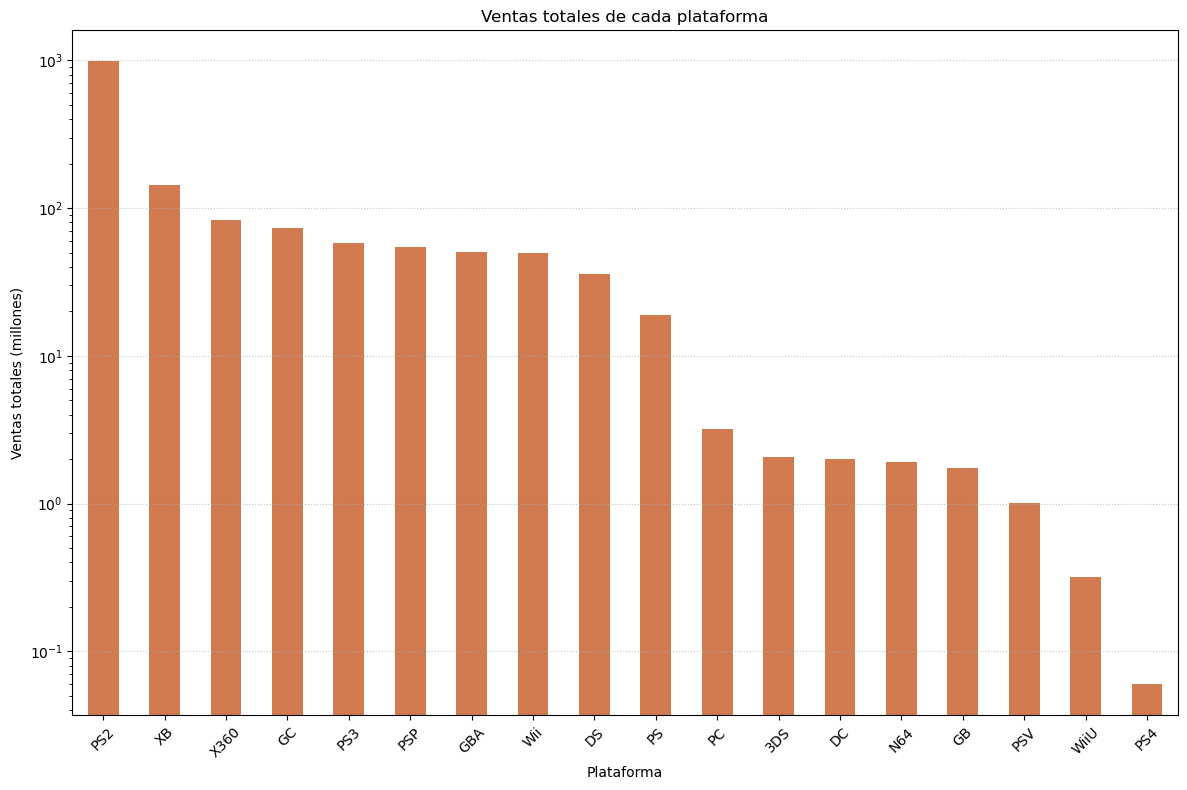

In [52]:
mplatform_games = mplatform_games.pivot_table(index='platform',values='total_sales',aggfunc='sum').reset_index().sort_values(by='total_sales',ascending=False)
mplatform_games.plot(kind='bar',
                    x='platform',
                    y='total_sales',
                    title='Ventas totales de cada plataforma',
                    xlabel='Plataforma',
                    ylabel='Ventas totales (millones)',
                    color="#D1794F",
                    rot=45,
                    figsize=[12,8],
                    legend=False
                   )
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.yscale('log')
plt.show()

La gráfica muestra las ventas totales por plataforma utilizando una escala logarítmica en el eje vertical, lo que permite visualizar diferencias significativas entre valores de distinta magnitud.

En primer lugar, se observa que PS2 lidera ampliamente las ventas, superando de forma considerable al resto de las plataformas. Esta diferencia indica una fuerte dominancia en su generación y una penetración de mercado excepcional.

En segundo lugar, existe una brecha notable entre la plataforma con mayores ventas y el segundo lugar. Ninguna otra consola logra acercarse al volumen alcanzado por PS2, lo que evidencia una concentración importante del mercado en dicha plataforma.

Asimismo, plataformas como X360, GC, PS3, PSP, GBA y Wii presentan niveles de ventas relativamente cercanos entre sí, lo que sugiere una competencia más equilibrada dentro de ese grupo intermedio.

Por otro lado, consolas como PC, 3DS, DC, N64, GB, PSV, WiiU y PS4 muestran ventas considerablemente menores en comparación con las líderes. La escala logarítmica permite apreciar que las diferencias entre los niveles superiores e inferiores son de varios órdenes de magnitud.

En conclusión, el análisis evidencia que el mercado de videojuegos no se distribuye de manera uniforme entre plataformas, sino que presenta una alta concentración en pocas consolas, destacando particularmente el caso de PS2 como líder dominante.

### Ventas de videojuegos por genero

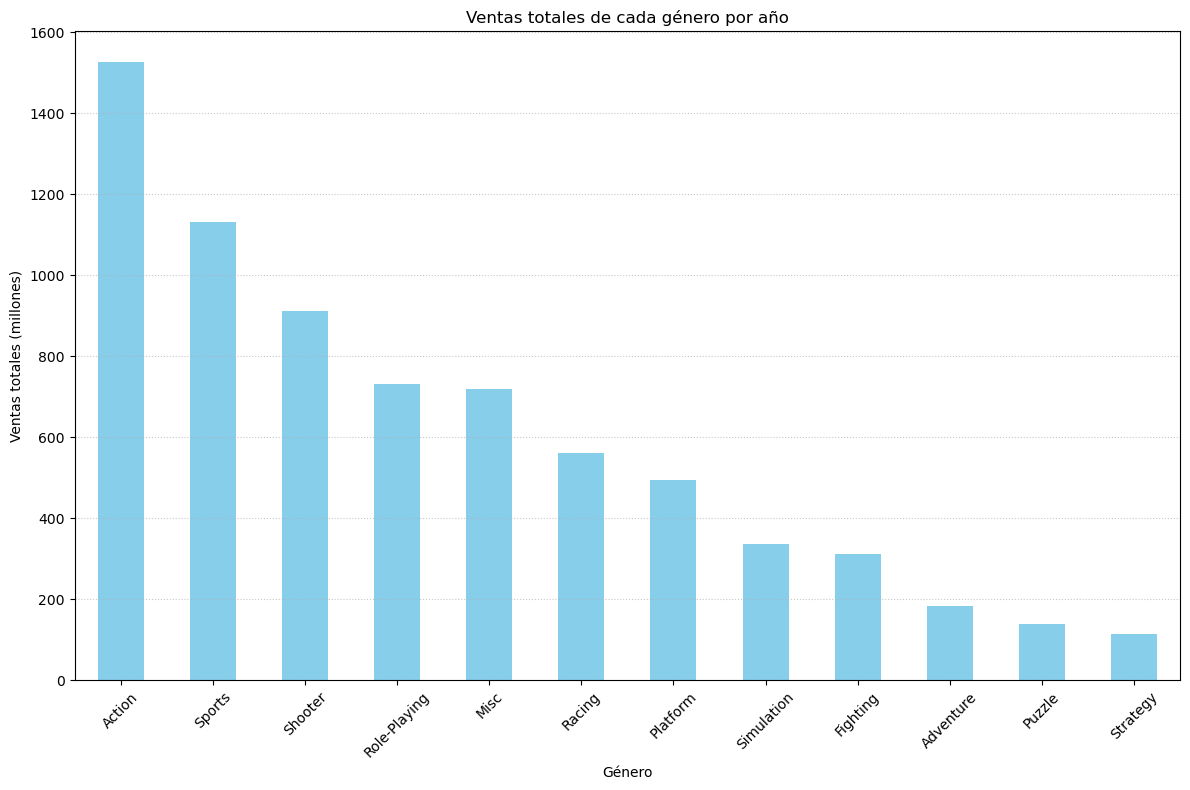

In [53]:
genre_games = recent_games.pivot_table(index='genre',values='total_sales',aggfunc='sum').reset_index().sort_values(by='total_sales',ascending=False)
genre_games.plot(kind='bar',
                    x='genre',
                    y='total_sales',
                    title='Ventas totales de cada género por año',
                    xlabel='Género',
                    ylabel='Ventas totales (millones)',
                    color='skyblue',
                    rot=45,
                    figsize=[12,8],
                    legend=False
                   )
plt.tight_layout()
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.show()

A partir de la gráfica de ventas totales por género entre 2000 y 2016, se observa una marcada concentración del mercado en unos pocos géneros. Acción, Deportes y Disparos representan aproximadamente la mitad del total de ventas, lo que evidencia una fuerte preferencia por experiencias dinámicas y competitivas. Asimismo, géneros como Role-Playing y Misc mantienen una participación relevante, aunque considerablemente menor en comparación con los líderes.

Por otro lado, géneros como Strategy, Puzzle y Adventure presentan los niveles más bajos de ventas acumuladas, lo que sugiere que se dirigen a nichos más específicos dentro del mercado. La diferencia entre el género con mayores ventas (Acción) y el de menor desempeño (Strategy) refleja una brecha significativa en términos de popularidad y consumo.

En conjunto, los datos indican que, durante el periodo analizado, el mercado de videojuegos estuvo dominado por propuestas de alta intensidad, competitividad y fuerte componente de rejugabilidad, posiblemente impulsadas por el crecimiento del juego en línea y la consolidación de franquicias comerciales de gran alcance.

## 👤 Creación de perfiles de usuarios

### Plataformas principales

In [32]:
platforms_total = []
for sales in ['na_sales','eu_sales','jp_sales']:
    df_total = recent_games.groupby('platform')[sales].sum().reset_index()
    df_total = df_total.sort_values(by=sales, ascending=False).head()
    platforms_total.append(df_total)

# Usamos functools.reduce para hacer merge sucesivos
total = reduce(lambda left, right: pd.merge(left, right, on='platform', how='outer'), platforms_total)
total = total.fillna(0)
total['total_top5'] = (total['na_sales'] + total['eu_sales'] + total['jp_sales'])
total['na_sales'] = (total['na_sales'] / total['total_top5'])*100
total['eu_sales'] = (total['eu_sales'] / total['total_top5'])*100

total['jp_sales'] = (total['jp_sales'] / total['total_top5'])*100
print('Representación en porcentaje de las ventas por plataforma en cada región:\n',total.head(7))

Representación en porcentaje de las ventas por plataforma en cada región:
   platform   na_sales   eu_sales    jp_sales  total_top5
0      3DS   0.000000   0.000000  100.000000      100.62
1       DS  51.136180  25.333459   23.530361      743.72
2      PS2  54.925270  31.888907   13.185823     1043.09
3      PS3  48.965171  41.068089    9.966740      796.75
4      PSP   0.000000   0.000000  100.000000       75.88
5      Wii  65.335015  34.664985    0.000000      745.19
6     X360  68.946601  31.053399    0.000000      864.06


### Géneros principales

In [33]:
top_generos = {}
for sales in ['na_sales', 'eu_sales', 'jp_sales']:
    genre_top = (recent_games.groupby('genre')[sales].sum().sort_values(ascending=False).head().index.tolist()) 
    top_generos[f'genre_{sales}'] = genre_top
df_top = pd.DataFrame({region: pd.Series(generos) for region, generos in top_generos.items()})
print('Principales plataformas por región:\n',df_top)


Principales plataformas por región:
   genre_na_sales genre_eu_sales genre_jp_sales
0         Action         Action   Role-Playing
1         Sports         Sports         Action
2        Shooter        Shooter           Misc
3           Misc           Misc         Sports
4   Role-Playing         Racing       Platform


Se puede observar que la preferencia de géneros entre las regiones de Norteamérica y Europa es prácticamente idéntica, salvo por los géneros de Role-Playing y Racing, que no coinciden en ambas. En el caso de Japón, es evidente que los gustos y la popularidad de los géneros cambian considerablemente, debido a factores culturales, sociales e incluso económicos.

### Afectación del ESRB en ventas

In [34]:
sales_by_rating = recent_games.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum().reset_index().sort_values(by=['na_sales', 'eu_sales', 'jp_sales'],ascending=False)
print('Ventas por calificación en cada región: \n',sales_by_rating)

Ventas por calificación en cada región: 
     rating  na_sales  eu_sales  jp_sales
1        E   1249.26    690.61    189.91
4        M    727.80    472.40     57.84
6        T    709.86    392.71    131.01
7  Unknown    494.40    345.81    396.86
2     E10+    345.50    183.33     40.20
3       EC      1.53      0.11      0.00
0       AO      1.26      0.61      0.00
5       RP      0.00      0.03      0.00


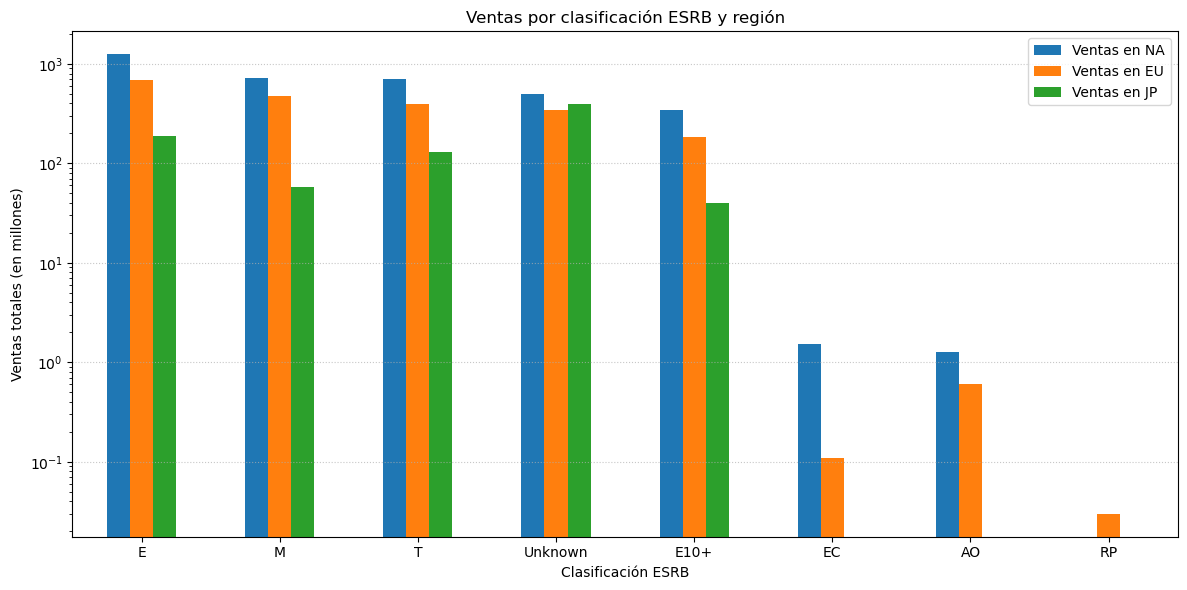

In [55]:
sales_by_rating.set_index('rating').plot(kind='bar', 
                                         figsize=(12,6), 
                                         title='Ventas por clasificación ESRB y región',
                                         rot=0)

plt.legend(['Ventas en NA', 'Ventas en EU', 'Ventas en JP'])
plt.xlabel('Clasificación ESRB')
plt.ylabel('Ventas totales (en millones)')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.yscale('log')
plt.show()

La clasificación ESRB influye en el desempeño comercial, siendo los juegos para público general (**E**) y adolescente (**T**) los más exitosos globalmente. Sin embargo, el impacto de cada clasificación varía según la región, lo que evidencia diferencias culturales y de mercado entre Norteamérica, Europa y Japón.

## 📝 Prueba de hipótesis

La hipótesis nula es aquella que se formula para verificar que no hubo ningún cambio entre dos grupos de muestras estadísticas. Por el contrario, la hipótesis alternativa busca comprobar la existencia de diferencias entre esas mismas dos muestras, sin importar si son mayores o menores. En este caso, la primera se considera como hipótesis nula y la segunda como hipótesis alternativa; únicamente fue necesario deducir las hipótesis faltantes siguiendo el criterio marcado por las definiciones.

En cuanto al criterio adoptado para las pruebas de hipótesis, se tomó un nivel de significancia $\alpha$ del 5%. Además de ser un valor bastante común en este tipo de pruebas, se utiliza porque asegura que la diferencia encontrada entre las muestras sea lo suficientemente grande como para no atribuir esas variaciones al azar

### Hipótesis 1

**Hipótesis nula:** Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son las mismas.

**Hipótesis alternativa:** Las calificaciones promedio de los usuarios para las plataformas Xbox One y PC son diferentes.

In [36]:
xone_score = games[~(games['user_score'].isna()) & (games['platform'] == 'XOne')]
pc_score = games[~(games['user_score'].isna()) & (games['platform'] == 'PC')]

In [37]:
# Prueba las hipótesis
alpha = 0.05 # la significancia estadística crítica (umbral)
# realizar una prueba
results_score = st.ttest_ind(xone_score['user_score'], pc_score['user_score'],equal_var = False)
# imprimir el valor p resultante
print('P-Value: ', results_score.pvalue)
# comparar el valor p con el umbral
if (results_score.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

P-Value:  0.007073035808555002
Rechazamos la hipótesis nula


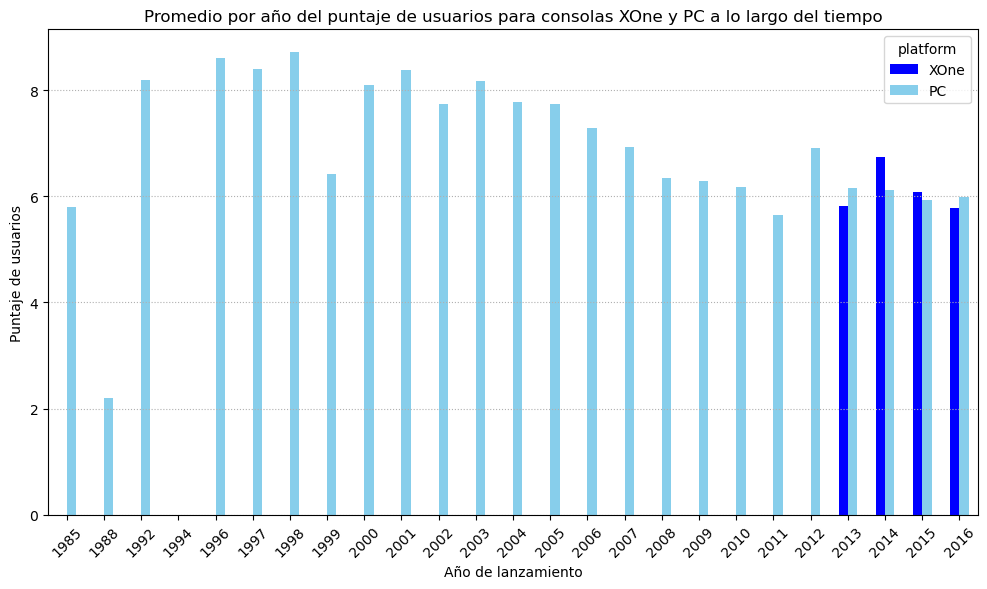

In [38]:
consoles = games.pivot_table(index='year_of_release', columns='platform', values='user_score', aggfunc='mean').reset_index()
consoles.plot(x='year_of_release', 
            y=['XOne', 'PC']
            ,kind='bar',
            title='Promedio por año del puntaje de usuarios para consolas XOne y PC a lo largo del tiempo',
            xlabel='Año de lanzamiento',
            ylabel='Puntaje de usuarios', 
            figsize=(10,6),
            rot=45,
            color=['blue','skyblue'])
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()

Para contrastar los resultados, se observa que el promedio del puntaje otorgado por los usuarios a los juegos de la consola Xbox One y de PC es completamente diferente. Mientras que el tiempo de vida de la PC se remonta a los años 80, la consola de Microsoft apenas inicia su trayectoria a comienzos de la década de 2010. Por lo tanto, esta diferencia respalda el resultado de la prueba de hipótesis realizada anteriormente.


### Hipótesis 2

**Hipótesis nula:** Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son las mismas.

**Hipótesis alternativa:** Las calificaciones promedio de los usuarios para los géneros de Acción y Deportes son diferentes.

In [39]:
action_score = games[~(games['user_score'].isna()) & (games['genre'] == 'Action')]
sports_score = games[~(games['user_score'].isna()) & (games['genre'] == 'Sports')]

In [40]:
results_genre = st.ttest_ind(action_score['user_score'], sports_score['user_score'],equal_var = False)
# imprimir el valor p resultante
print('P-Value: ', results_genre.pvalue)
# comparar el valor p con el umbral
if (results_genre.pvalue < alpha):
    print("Rechazamos la hipótesis nula")
else:
    print("No podemos rechazar la hipótesis nula")

P-Value:  1.8755843984029145e-13
Rechazamos la hipótesis nula


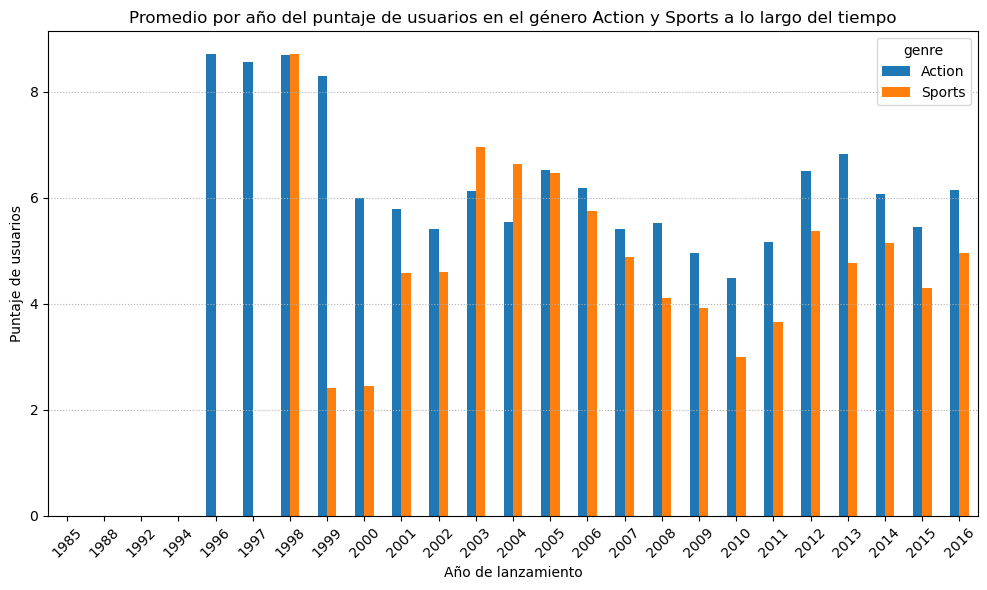

In [41]:
scores = games.pivot_table(index='year_of_release', columns='genre', values='user_score', aggfunc='mean').reset_index()
scores.plot(x='year_of_release', 
            y=['Action', 'Sports']
            ,kind='bar',
            title='Promedio por año del puntaje de usuarios en el género Action y Sports a lo largo del tiempo',
            xlabel='Año de lanzamiento',
            ylabel='Puntaje de usuarios', 
            figsize=(10,6),
            rot=45)
plt.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()


La gráfica sugiere que el género de acción ha sido el más valorado y popular a lo largo del tiempo, en comparación con el de deportes, aunque las ventas de estos títulos disminuyeron a inicios de los años 2000. Este comportamiento podría explicarse por factores como la sobreexplotación del género, el surgimiento de títulos más exitosos en otros géneros o el contexto social en el que se desarrollaba la industria de los videojuegos en esa época.

## ✅ Conclusiones

**Conclusiones referentes a la realización del proyecto:**

Este proyecto, a diferencia de los anteriores, representó un reto mayor al otorgar la libertad de calcular cada una de las secciones de acuerdo con lo aprendido en los sprints previos. Si bien es importante seguir una metodología definida para la resolución de problemas, no siempre se debe tomar la misma ruta. Un claro ejemplo se encontró dentro de este proyecto: aunque gran parte del proceso es similar —pues en gran medida se requiere agrupar, filtrar, modificar, agregar o eliminar información— cada proyecto tiene objetivos y necesidades distintas que dependen de lo que se busca obtener del conjunto de datos a analizar.

Un aspecto importante a resaltar es que, para hacer más eficiente la resolución de cada análisis, resulta fundamental comprender con claridad lo que se requiere. Una buena interpretación de lo solicitado genera los resultados deseados, conclusiones correctas y, lo más importante, reduce el tiempo de resolución.

En perspectiva, muchos de los elementos trabajados durante este proyecto serán de gran utilidad en futuros análisis, tanto en la parte de codificación como en la interpretación. Si bien aún quedan aspectos por aprender, cada vez será más sencillo manejar grandes volúmenes de información para su procesamiento.

**Conclusiones referentes al objetivo del proyecto:**

El análisis muestra que el auge de los videojuegos comenzó a mediados de los años 90 y alcanzó su punto máximo hacia finales de la década de 2010, con consolas populares como PlayStation, Nintendo DS, Wii, Xbox360 y PS2, que tuvieron ciclos de vida largos y ventas significativas. En contraste, las consolas menos populares presentaron ciclos más cortos y ventas reducidas, lo que evidencia que la permanencia y el éxito dependen de factores como la innovación, la estrategia de lanzamiento y la capacidad de mantener el interés del público.

Asimismo, se observa que aunque la crítica y los usuarios influyen en las ventas, su impacto es moderado frente a otros elementos como la popularidad de la franquicia, el marketing, la distribución y el contexto social. Los géneros más exitosos —acción, deportes y disparos— concentran la mayor parte de las ventas, mientras que las clasificaciones de público general y adolescentes son las que generan mayor volumen de mercado.

En consecuencia, una campaña de marketing debería enfocarse en:
- **Resaltar géneros de mayor demanda** (acción, deportes, disparos).
- **Aprovechar las clasificaciones más rentables** (público general y adolescentes).
- **Construir estrategias diferenciadas por género**, alineadas a las preferencias y disposición de pago de los consumidores.
- **Fortalecer la reputación de la marca y la franquicia**, dado que son factores decisivos en las ventas.
- **Planificar lanzamientos estratégicos** que coincidan con momentos de mayor interés del mercado, evitando la sobreexplotación del género.
